## Award Table Cleaning (Players_Teams)

In [ ]:
# Load datasets
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

players_teams = pd.read_csv("../../data/initial_data/players_teams.csv")
awards = pd.read_csv("../../data/initial_data/awards_players.csv")
players = pd.read_csv("../../data/initial_data/players_clean.csv")

### Attribute correlation players_teams table

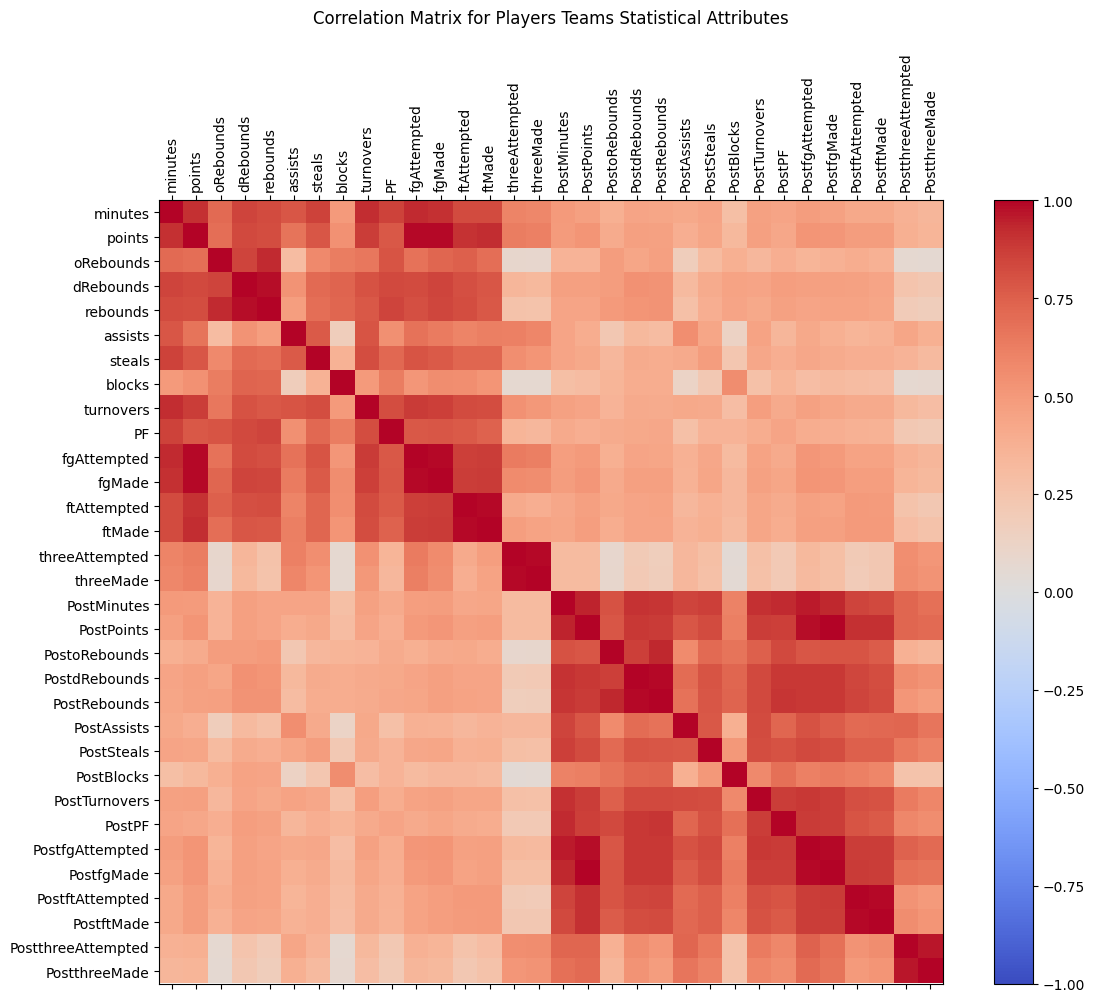

Correlation matrix includes 32 statistical attributes


In [348]:
# Since we use the players_teams dataset to calculate awards given each year and predict, we should check how each attribute correlates with others

# Select only numeric columns that represent basketball statistics (exclude IDs and categorical columns)
numeric_cols = players_teams.select_dtypes(include=[np.number]).columns.tolist()
# Remove non-statistical columns like year and stint
cols_to_exclude = ['year', 'stint', 'GP', 'GS', 'dq', 'PostGP', 'PostGS', 'PostDQ']
stats_cols = [col for col in numeric_cols if col not in cols_to_exclude]

corr = players_teams[stats_cols].corr()
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(stats_cols), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(stats_cols, rotation=90)
ax.set_yticklabels(stats_cols)
plt.title('Correlation Matrix for Players Teams Statistical Attributes', pad=20)
plt.tight_layout()
plt.show()

print(f"Correlation matrix includes {len(stats_cols)} statistical attributes")


### Feature Selection for Prediction Models

Based on the correlation matrix above, we need to reduce the number of features to avoid multicollinearity and overfitting. We'll:
1. Identify highly correlated features (redundant information)
2. Create composite/engineered features (efficiency metrics)
3. Select the most important features for prediction

In [349]:
# Step 1: Identify highly correlated features (>0.85 correlation)
# These features provide redundant information

def find_high_correlation_pairs(corr_matrix, threshold=0.85):
    """Find pairs of features with correlation above threshold"""
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    return pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)

"""
high_corr = find_high_correlation_pairs(corr, threshold=0.85)
print("Highly correlated feature pairs (>0.85):")
print(high_corr.to_string())
print(f"\nTotal pairs: {len(high_corr)}")
"""

def find_high_correlation_many(corr_matrix, threshold=0.85):
    """ Find sets of features that are all highly correlated with each other """
    visited = set()
    high_corr_sets = []

    for i in range(len(corr_matrix.columns)):
        if corr_matrix.columns[i] in visited:
            continue
        current_set = {corr_matrix.columns[i]}
        for j in range(len(corr_matrix.columns)):
            if i != j and abs(corr_matrix.iloc[i, j]) > threshold:
                current_set.add(corr_matrix.columns[j])
                visited.add(corr_matrix.columns[j])
        if len(current_set) > 1:
            high_corr_sets.append(current_set)
            visited.update(current_set)

    return high_corr_sets

high_corr_sets = find_high_correlation_many(corr, threshold=0.90)
print("\nSets of highly correlated features (>0.90):")
for s in high_corr_sets:
    print(s)
print(f"\nTotal sets: {len(high_corr_sets)}")

high_corr_sets2 = find_high_correlation_many(corr, threshold=0.85)
print("\nSets of highly correlated features (>0.85):")
for s in high_corr_sets2:
    print(s)
print(f"\nTotal sets: {len(high_corr_sets2)}")

high_corr_sets3 = find_high_correlation_many(corr, threshold=0.80)
print("\nSets of highly correlated features (>0.80):")
for s in high_corr_sets3:
    print(s)
print(f"\nTotal sets: {len(high_corr_sets3)}")



Sets of highly correlated features (>0.90):
{'turnovers', 'fgAttempted', 'points', 'minutes', 'fgMade'}
{'rebounds', 'oRebounds'}
{'rebounds', 'dRebounds'}
{'points', 'ftAttempted', 'ftMade'}
{'threeAttempted', 'threeMade'}
{'PostPoints', 'PostTurnovers', 'PostfgMade', 'PostfgAttempted', 'PostMinutes', 'PostPF'}
{'PostRebounds', 'PostoRebounds'}
{'PostRebounds', 'PostdRebounds'}
{'PostPoints', 'PostftMade', 'PostftAttempted'}
{'PostthreeMade', 'PostthreeAttempted'}

Total sets: 10

Sets of highly correlated features (>0.85):
{'turnovers', 'fgAttempted', 'fgMade', 'points', 'steals', 'PF', 'minutes'}
{'rebounds', 'oRebounds'}
{'rebounds', 'dRebounds'}
{'fgAttempted', 'ftAttempted', 'points', 'ftMade', 'fgMade'}
{'threeAttempted', 'threeMade'}
{'PostSteals', 'PostPoints', 'PostTurnovers', 'PostdRebounds', 'PostfgMade', 'PostfgAttempted', 'PostMinutes', 'PostRebounds', 'PostPF'}
{'PostRebounds', 'PostoRebounds', 'PostdRebounds'}
{'PostPoints', 'PostfgMade', 'PostfgAttempted', 'PostftAtte

### Creating new dataset with engineered features for awards

In [350]:
# Create a new DataFrame with selected + engineered features
players_teams_clean = pd.DataFrame({
    "playerID": players_teams["playerID"],
    "year": players_teams["year"],
    "team": players_teams["tmID"],
    
    # Playing time (IMPORTANT: helps filter out anomalies)
    "minutes": players_teams["minutes"],
    "games_played": players_teams["GP"],
    "minutes": players_teams["minutes"],  # For filtering and weighting
    "total_points": players_teams["points"],  # Raw volume stats
    "total_rebounds": players_teams["rebounds"],
    "total_assists": players_teams["assists"],

    # Per-minute efficiency stats
    "points_per_min": players_teams["points"] / players_teams["minutes"],
    "assists_per_min": players_teams["assists"] / players_teams["minutes"],
    "rebounds_per_min": players_teams["rebounds"] / players_teams["minutes"],
    "steals_per_min": players_teams["steals"] / players_teams["minutes"],
    "blocks_per_min": players_teams["blocks"] / players_teams["minutes"],
    "turnovers_per_min": players_teams["turnovers"] / players_teams["minutes"],

    # Shooting efficiencies
    "FG%": players_teams["fgMade"] / players_teams["fgAttempted"],
    "FT%": players_teams["ftMade"] / players_teams["ftAttempted"],
    "Three%": players_teams["threeMade"] / players_teams["threeAttempted"],

    # Play style
    "Three Rate": players_teams["threeAttempted"] / players_teams["fgAttempted"],  # share of shots from 3s
})

# Handle any divide-by-zero or NaN issues
players_teams_clean = players_teams_clean.replace([float('inf'), -float('inf')], pd.NA).fillna(0)

# Save dataframe
players_teams_clean.to_csv("project_data/awards_data/players_teams_clean.csv", index=False)

# Show statistics about playing time
print("Playing Time Statistics:")
print(f"Min minutes: {players_teams_clean['minutes'].min()}")
print(f"Max minutes: {players_teams_clean['minutes'].max()}")
print(f"Mean minutes: {players_teams_clean['minutes'].mean():.1f}")
print(f"Median minutes: {players_teams_clean['minutes'].median():.1f}")
print(f"\nPlayers with < 100 minutes: {(players_teams_clean['minutes'] < 100).sum()}")
print(f"Players with < 200 minutes: {(players_teams_clean['minutes'] < 200).sum()}")

# Save or preview
print("\nSample of data:")
print(players_teams_clean.head(10))

Playing Time Statistics:
Min minutes: 0
Max minutes: 1234
Mean minutes: 501.3
Median minutes: 459.0

Players with < 100 minutes: 330
Players with < 200 minutes: 535

Sample of data:
     playerID  year team  minutes  games_played  total_points  total_rebounds  \
0  abrossv01w     2  MIN      846            26           343             174   
1  abrossv01w     3  MIN      805            27           314             146   
2  abrossv01w     4  MIN      792            30           318             141   
3  abrossv01w     5  MIN      462            22           146              74   
4  abrossv01w     6  MIN      777            31           304             107   
5  abrossv01w     7  MIN      724            34           263             106   
6  abrossv01w     8  MIN      843            34           345             150   
7  abrossv01w     9  CON      107             6            34              20   
8  adamsjo01w     4  MIN       96            10            33              23   
9  aguil

### Correlation Matrix for the newly created dataframe

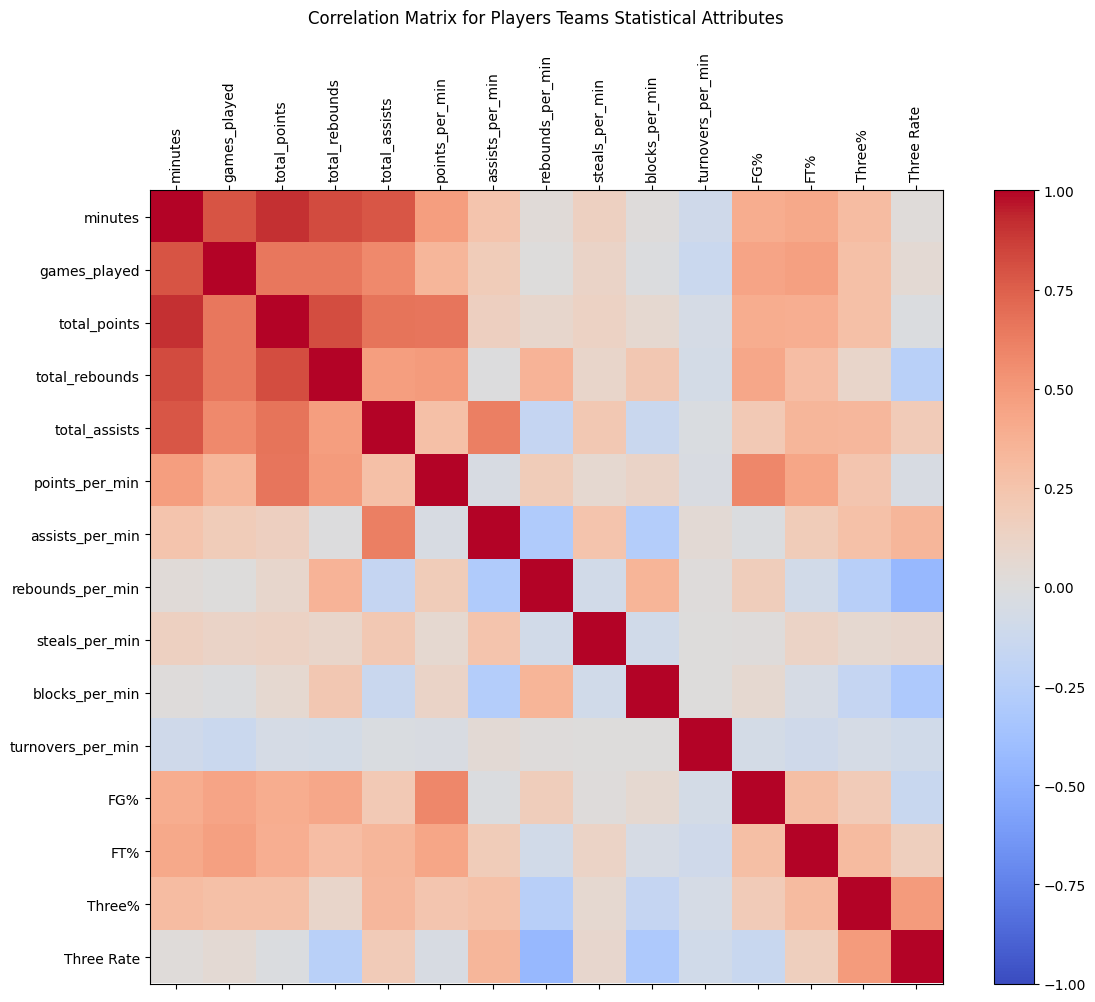

Correlation matrix includes 15 statistical attributes


In [351]:
# Find high corr sets of players_teams_clean

# Since we use the players_teams dataset to calculate awards given each year and predict, we should check how each attribute correlates with others

# Select only numeric columns that represent basketball statistics (exclude IDs and categorical columns)
numeric_cols = players_teams_clean.select_dtypes(include=[np.number]).columns.tolist()
# Remove non-statistical columns like year and stint
cols_to_exclude = ['year', 'stint', 'GP', 'GS', 'dq', 'PostGP', 'PostGS', 'PostDQ']
stats_cols = [col for col in numeric_cols if col not in cols_to_exclude]

corr = players_teams_clean[stats_cols].corr()
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(stats_cols), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(stats_cols, rotation=90)
ax.set_yticklabels(stats_cols)
plt.title('Correlation Matrix for Players Teams Statistical Attributes', pad=20)
plt.tight_layout()
plt.show()

print(f"Correlation matrix includes {len(stats_cols)} statistical attributes")


## 